In [37]:
# saves you having to use print as all exposed variables are printed in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# core libraries
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# matpolitlib config
%matplotlib inline
sns.reset_defaults()
plt.rcParams['figure.figsize'] = 12,4
sns.set_style('whitegrid')

# suppress warning message
import warnings
warnings.filterwarnings('ignore')

os.environ['AISTAC_PM_PATH'] = Path(os.environ['PWD'], 'contracts').as_posix()

%reload_ext autoreload
%autoreload 2

import ds_discovery
import ds_behavioral
print('DTU: {}'.format(ds_discovery.__version__))
print('DBU: {}'.format(ds_behavioral.__version__))

DTU: 2.05.056
DBU: 1.03.081


# Titanic Dataset



In [38]:
from ds_behavioral import DataBuilderTools as tools
from ds_discovery.transition.transitioning import Transition
from ds_behavioral.sample.sample_data import ProfileSample

In [39]:
tr = Transition.from_env('titanic')

In [40]:
titanic = sns.load_dataset('titanic')

In [41]:
titanic = tr.intent_model.auto_to_category(titanic)

In [42]:
tr.canonical_report(titanic)

,Attribute,dType,%_Null,%_Dom,Count,Unique,Observations
0,adult_male,bool,0.0%,60.3%,891,2,True | False
1,age,float64,19.9%,19.9%,891,89,max=80.0 | min=0.42 | mean=29.7
2,alive,category,0.0%,61.6%,891,2,no|yes
3,alone,bool,0.0%,60.3%,891,2,False | True
4,class,category,0.0%,55.1%,891,3,First|Second|Third
5,deck,category,77.2%,77.2%,891,8,A|B|C|D|E|F|G
6,embark_town,category,0.2%,72.3%,891,4,Cherbourg|Queenstown|Southampton
7,embarked,category,0.2%,72.3%,891,4,C|Q|S
8,fare,float64,0.0%,4.8%,891,248,max=512.3292 | min=0.0 | mean=32.2
9,parch,int64,0.0%,76.1%,891,7,max=6 | min=0 | mean=0.38


### Replace NaN's from Age
We could clean NaN's in age with 

`tr.intent_model.to_int_type(titanic, headers=['age'], fillna='mode', inplace=True)`

Which would fill the age NaN's with the mode of the age (see Cleaner.to_int_type(...) for more info)

But ultimately it will just fill NaN values with a single value. Not ideal

Alternatively: We can use our analysis tool to get an age weighting and then replace NaN with values that represent that weighting, giving us a much more representative distribution

In [43]:
# firstly get the analysis dictionary with an age frequency of 5 years, keep the lower boundary as 1
analysis = tr.discover.analyse_number(titanic['age'], granularity=5.0, lower=1)
lower = analysis['intent'].get('lower')
upper = analysis['intent'].get('upper')
weight_pattern = analysis.get('weighting')

# now replace the nan's with a representative distribution
size = len(titanic['age'][titanic['age'].isna()])
titanic['age'][titanic['age'].isna()] = tools.get_number(from_value=lower, to_value=upper, weight_pattern=weight_pattern, precision=0, size=size)

### Titanic Visualisation
A quick look over the origional titanic dataset

In [44]:
# Age against Fare
sns.set(style="ticks", color_codes=True)
g = sns.jointplot(x='fare',y='age',data=titanic, s=10)

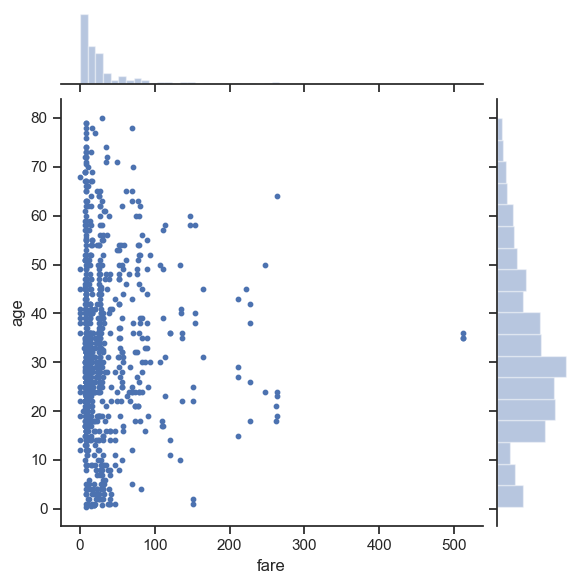

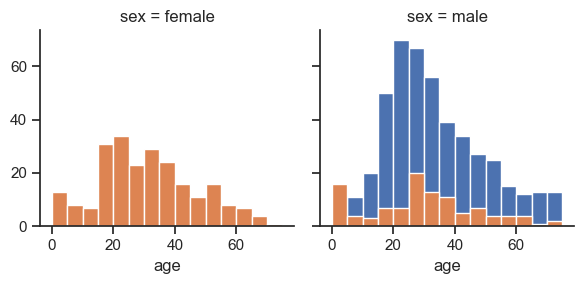

In [45]:
# Age Gender distribution of survived as a hue
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='sex', hue='survived')
g.map(plt.hist, 'age', bins=bins)
plt.show(g)

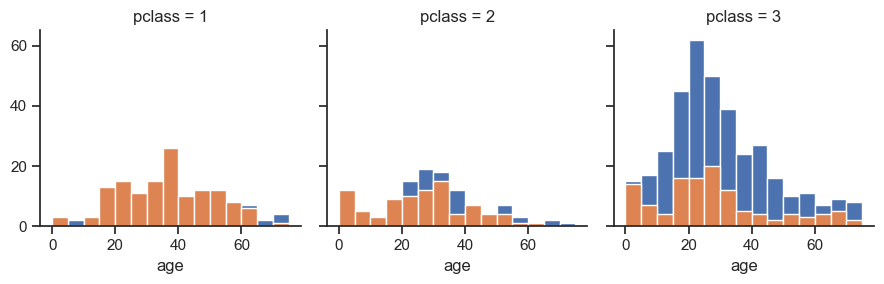

In [46]:
# Age against class with the hue of survived
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='pclass', hue='survived')
g.map(plt.hist, 'age', bins=bins)
plt.show(g)

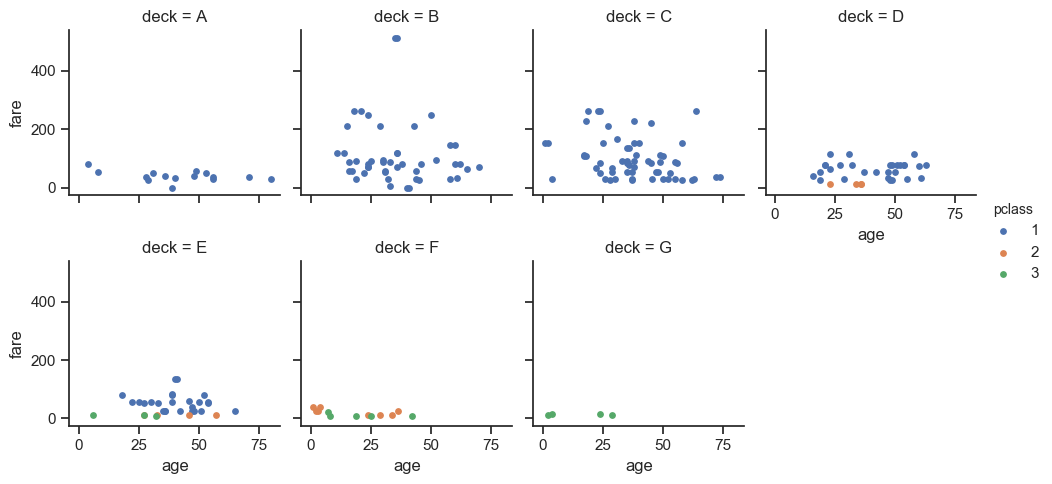

In [47]:
# Age against fair across the decks with a hueof class
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(data=titanic, col='deck', hue='pclass', col_wrap=4, height=2.5)
g = g.map(plt.scatter, 'age', 'fare', s=15).add_legend()
g.fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show(g)

# Synthetic Titanic dataset
Time to now build the synthetic data and see how it compares

## Clean the dataset

In [48]:
df = tr.intent_model.auto_to_category(titanic)
bool_map = {'yes': True, '1': True, 'True': True}
df = tr.intent_model.to_bool_type(df, bool_map=bool_map, headers=['adult_male', 'alive', 'alone', 'survived'])
tr.canonical_report(df)

,Attribute,dType,%_Null,%_Dom,Count,Unique,Observations
0,adult_male,bool,0.0%,60.3%,891,2,True | False
1,age,float64,0.0%,3.8%,891,97,max=80.0 | min=0.42 | mean=31.79
2,alive,bool,0.0%,61.6%,891,2,False | True
3,alone,bool,0.0%,60.3%,891,2,False | True
4,class,category,0.0%,55.1%,891,3,First|Second|Third
5,deck,category,77.2%,77.2%,891,8,A|B|C|D|E|F|G
6,embark_town,category,0.2%,72.3%,891,4,Cherbourg|Queenstown|Southampton
7,embarked,category,0.2%,72.3%,891,4,C|Q|S
8,fare,float64,0.0%,4.8%,891,248,max=512.3292 | min=0.0 | mean=32.2
9,parch,int64,0.0%,76.1%,891,7,max=6 | min=0 | mean=0.38


## Characteristics of the dataset
By using the analysis tools we can extract out the relational charactersitcs of the dataset

#### Create the columns association reference
This reference dictionary outlines how we percived the columns in the dataset and their levels of associating
- level 1
    - sex
- level 2
    - age
- level 3
    - pclass
    - sibsp - **end**
- level 4
    - alone - **end**
    - survived - **end**
    - fare 
- level 5 
    - embarked - **end**

In [49]:
column_association = [{'sex': {}}, 
                      {'age': {'granularity': 16, 'precision': 0}}, 
                      {'pclass': {'dtype': 'category'}, 'sibsp': {'dtype': 'category'}},
                      {'survived': {'dtype': 'category'}, 'fare': {'granularity': 20, 'precision': 2}, 'alone': {'dtype': 'category'}},
                      {'embarked': {}}]

exclude_associate = ['sex.age.sibsp.fare', 'sex.age.sibsp.survived', 'sex.age.sibsp.alone', 'sex.age.pclass.survived.embarked', 'sex.age.pclass.alone.embarked']

analysis = tr.discover.analyse_association(titanic, columns_list=column_association, exclude_associate=exclude_associate)


TypeError: unhashable type: 'list'

In [24]:
df_syn = tools.associate_analysis(analysis)

IndexingError: Too many indexers

Add in the 'embark_town' by correlating the 'embarked' categories

In [ ]:
actions = {0: {'action': 'Cherbourg'}, 1: {'action': 'Southampton'}, 2: {'action': 'Queenstown'}}
df_syn['embark_town'] = tools.correlate_categories(df_syn['embarked'], correlations=['C', 'S', 'Q'], actions=actions, value_type='category')


The last field of interest is the decks. We can analyse the decks from the class. we can then build an association

In [ ]:
column_association = [{'pclass': {'dtype': 'category'}}, {'deck': {}}]
analysis = Discover.analyse_association(titanic, columns_list=column_association)
selection_1 = analysis.get('pclass').get('sub_category').get(1).get('deck').get('analysis').get('selection')
weighting_1 = analysis.get('pclass').get('sub_category').get(1).get('deck').get('analysis').get('weighting')
selection_2 = analysis.get('pclass').get('sub_category').get(2).get('deck').get('analysis').get('selection')
weighting_2 = analysis.get('pclass').get('sub_category').get(2).get('deck').get('analysis').get('weighting')
selection_3 = analysis.get('pclass').get('sub_category').get(3).get('deck').get('analysis').get('selection')
weighting_3 = analysis.get('pclass').get('sub_category').get(3).get('deck').get('analysis').get('weighting')


In [ ]:
associations = [{'pclass': {'expect': 'category', 'value': [1]}},
                {'pclass': {'expect': 'category', 'value': [2]}},
                {'pclass': {'expect': 'category', 'value': [3]}}]

actions = {0: {'action': 'get_category', 'kwargs' : {'selection': selection_1, 'weight_pattern': weighting_1}},
           1: {'action': 'get_category','kwargs' : {'selection': selection_2, 'weight_pattern': weighting_2}},
           2: {'action': 'get_category','kwargs' : {'selection': selection_3, 'weight_pattern': weighting_3}}}

df_syn['deck'] = tools.associate_dataset(df_syn, associations=associations, actions=actions, default_value='')

In [ ]:
builder.save_to_disk(df_syn, filename='darryl_titanic_2.csv')

In [ ]:
Discover.data_dictionary(df_syn)

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.jointplot(x='fare',y='age',data=df_syn, s=10)
plt.show(g)

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.jointplot(x='fare',y='age',data=titanic, s=10)
plt.show(g)

In [ ]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=df_syn, col='sex', hue='survived')
g.map(plt.hist, 'age', bins=bins)
plt.show(g)

In [ ]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='sex', hue='survived')
g.map(plt.hist, 'age', bins=bins)
plt.show(g)

In [ ]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=df_syn, col='pclass', hue='survived')
g.map(plt.hist, 'age', bins=bins)
plt.show(g)

In [ ]:
sns.set(style="ticks", color_codes=True)
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(data=titanic, col='pclass', hue='survived')
g.map(plt.hist, 'age', bins=bins)
plt.show(g)

In [ ]:
df_syn = df_syn.sort_values(by=['deck'])
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(data=df_syn, col='deck', hue='pclass', col_wrap=4, height=2.5)
g = g.map(plt.scatter, 'age', 'fare', s=15).add_legend()
g.fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show(g)

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(data=titanic, col='deck', hue='pclass', col_wrap=4, height=2.5)
g = g.map(plt.scatter, 'age', 'fare', s=15).add_legend()
g.fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show(g)